In [14]:
import pickle
import os, sys
sys.path.append("..")

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import torch
import torch.nn as nn
import torchvision
import gc
from src import distributions
import torch.nn.functional as F

from src.resnet2 import ResNet_D
from src.unet import UNet

from src.tools import unfreeze, freeze
from src.tools import load_dataset, get_Z_pushed_loader_stats
from src.fid_score import calculate_frechet_distance
from src.tools import weights_init_D
from src.plotters import plot_random_Z_images, plot_Z_images

from copy import deepcopy
import json

from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

import wandb
from src.tools import fig2data, fig2img # for wandb

# This needed to use dataloaders for some datasets
from PIL import PngImagePlugin
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)

## Main Config

In [60]:
DEVICE_IDS = [0]

DATASET1, DATASET1_PATH = 'colorization', '../datasets/colorization.h5'
DATASET2, DATASET2_PATH = 'shoes', '../datasets/shoes_128.hdf5'

# DATASET1, DATASET1_PATH = 'celeba_female', '../../data/img_align_celeba'
# DATASET2, DATASET2_PATH = 'aligned_anime_faces', '../../data/aligned_anime_faces'

T_ITERS = 20
f_LR, T_LR = 1e-4, 1e-4
IMG_SIZE = 64
ZC = 1
Z_STD = 0.1
Z_SIZE = 8
BATCH_SIZE = 32

PLOT_INTERVAL = 10
COST = 'mse' # Mean Squared Error
CPKT_INTERVAL = 2000
MAX_STEPS = 18000
SEED = 0x000000
GAMMA0, GAMMA1 = 0.0, 0.66
GAMMA_ITERS = 12500
EXP_NAME = f'{DATASET1}_{DATASET2}_T{T_ITERS}_{COST}_{IMG_SIZE}'
OUTPUT_PATH = '../checkpoints/{}/{}_{}_{}/'.format(COST, DATASET1, DATASET2, IMG_SIZE)

## Preparation

In [16]:
config = dict(
    DATASET1=DATASET1,
    DATASET2=DATASET2, 
    T_ITERS=T_ITERS,
    f_LR=f_LR, T_LR=T_LR,
    BATCH_SIZE=BATCH_SIZE
)
    
assert torch.cuda.is_available()
torch.cuda.set_device(f'cuda:{DEVICE_IDS[0]}')
torch.manual_seed(SEED); np.random.seed(SEED)

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

In [49]:
import torchvision.transforms as transforms
import PIL.Image as Image

dataset_dir = r"C:\Users\yoann\Desktop\Neural Optimal Transport\datasets\images\Images"


img_set = []
transformT = transforms.Compose([
    transforms.Resize((64, 64)),  # Ensure correct size,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) ])

for filename in os.listdir(dataset_dir):

    file_path_X = os.path.join(dataset_dir, filename)
    for img1 in os.listdir(file_path_X):
        img_path = os.path.join(file_path_X, img1)
        img = Image.open(img_path).convert("RGB")
        img = transformT(img)
        img_set.append(img)

In [33]:
import torchvision.transforms as transforms
import PIL.Image as Image

dataset_dir_1 = r"C:\Users\yoann\Desktop\Neural Optimal Transport\datasets\train\train\dog"


img_set1 = []
transformT = transforms.Compose([
    transforms.Resize((64, 64)),  # Ensure correct size,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) ])

for filename in os.listdir(dataset_dir_1):

    img_path = os.path.join(dataset_dir_1, filename)
    img = Image.open(img_path).convert("RGB")
    img = transformT(img)
    img_set1.append(img)

In [48]:
len(img_set1)

12500

In [50]:
len(img_set)

20580

In [51]:
train_dataset_X = img_set[:10000]  # Keep full dataset as normal images
train_dataset_Y = img_set1[:10000]

# Convert train_dataset_X to grayscale
transform_grayscale = transforms.Grayscale(num_output_channels=3)  # Keep 3 channels
train_dataset_X = [transform_grayscale(img) for img in train_dataset_X]

# Convert lists to tensors
train_dataset_X = torch.stack(train_dataset_X)
train_dataset_Y = torch.stack(train_dataset_Y)

In [53]:
test_dataset_X = img_set[10000:10300]
test_dataset_Y = img_set1[10000:10300]

transform_grayscale = transforms.Grayscale(num_output_channels=3)  # Keep 3 channels
test_dataset_X = [transform_grayscale(img) for img in test_dataset_X]

# Convert lists to tensors
test_dataset_X = torch.stack(test_dataset_X)
test_dataset_Y = torch.stack(test_dataset_Y)



## Prepare Samplers (X, Y)

In [54]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from src.distributions import LoaderSampler


device = "cuda"
 


X_sampler = LoaderSampler(DataLoader(train_dataset_X, shuffle=True, num_workers=8, batch_size=BATCH_SIZE), device)
Y_sampler = LoaderSampler(DataLoader(train_dataset_Y, shuffle=True, num_workers=8, batch_size=BATCH_SIZE), device)
X_test_sampler = LoaderSampler(DataLoader(test_dataset_X, shuffle=True, num_workers=8, batch_size=BATCH_SIZE), device)
Y_test_sampler = LoaderSampler(DataLoader(test_dataset_Y, shuffle=True, num_workers=8, batch_size=BATCH_SIZE), device)


# Initializing Networks

In [62]:
f = ResNet_D(IMG_SIZE, nc=3).cuda()
f.apply(weights_init_D)

T = UNet(3+ZC, 3, base_factor=48).cuda() # ZC - noise input channels z

if len(DEVICE_IDS) > 1:
    T = nn.DataParallel(T, device_ids=DEVICE_IDS)
    f = nn.DataParallel(f, device_ids=DEVICE_IDS)
    
print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

T params: 9716259
f params: 22933441


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


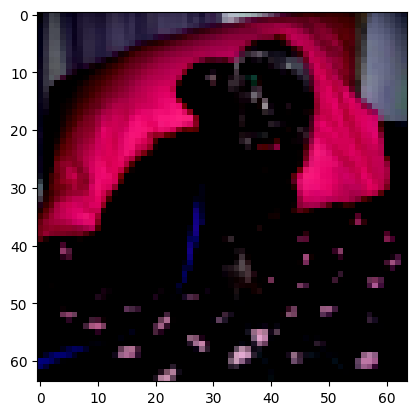

In [63]:
#plot an image from train_dataset_X
plt.imshow(train_dataset_Y[0].permute(1, 2, 0).cpu().numpy())


### Plots Test

# Run Training

In [64]:
T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=f_LR, weight_decay=1e-10)

In [58]:
torch.manual_seed(0xBADBEEF); np.random.seed(0xBADBEEF)
X_fixed = X_sampler.sample(10)[:,None].repeat(1,4,1,1,1)
with torch.no_grad():
    Z_fixed = torch.randn(10, 4, ZC, IMG_SIZE, IMG_SIZE, device='cuda') * Z_STD
    XZ_fixed = torch.cat([X_fixed, Z_fixed], dim=2)
del X_fixed, Z_fixed
Y_fixed = Y_sampler.sample(10)

X_test_fixed = X_test_sampler.sample(10)[:,None].repeat(1,4,1,1,1)
with torch.no_grad():
    Z_test_fixed = torch.randn(10, 4, ZC, IMG_SIZE, IMG_SIZE, device='cuda') * Z_STD
    XZ_test_fixed = torch.cat([X_test_fixed, Z_test_fixed], dim=2)
del X_test_fixed, Z_test_fixed
Y_test_fixed = Y_test_sampler.sample(10)

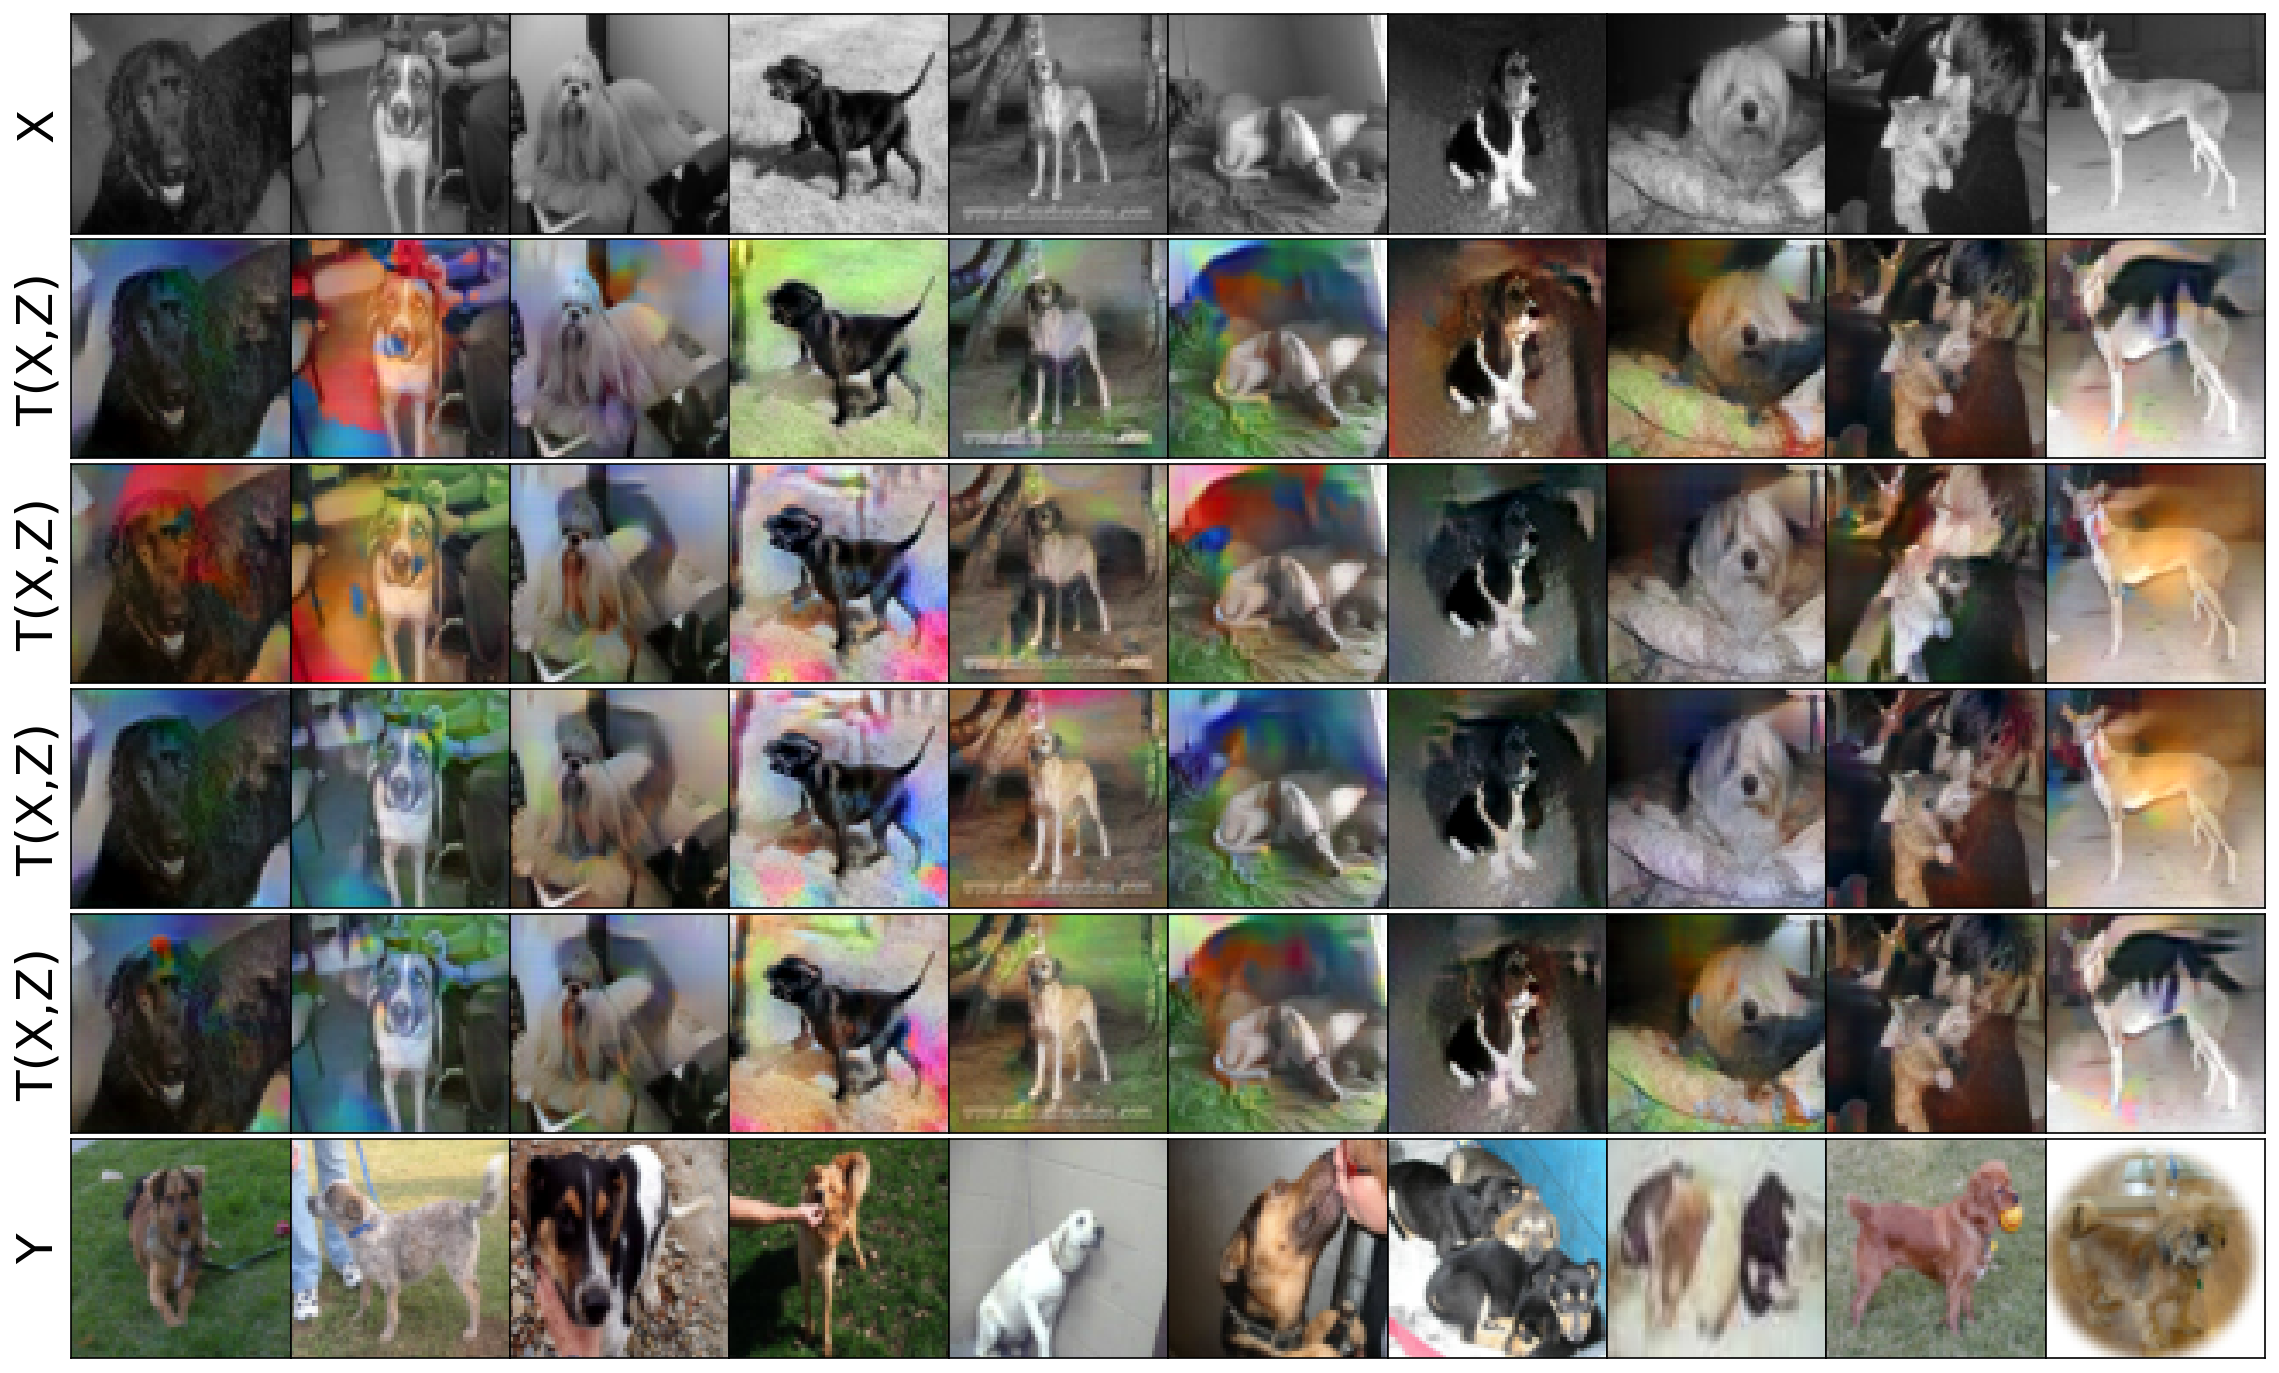

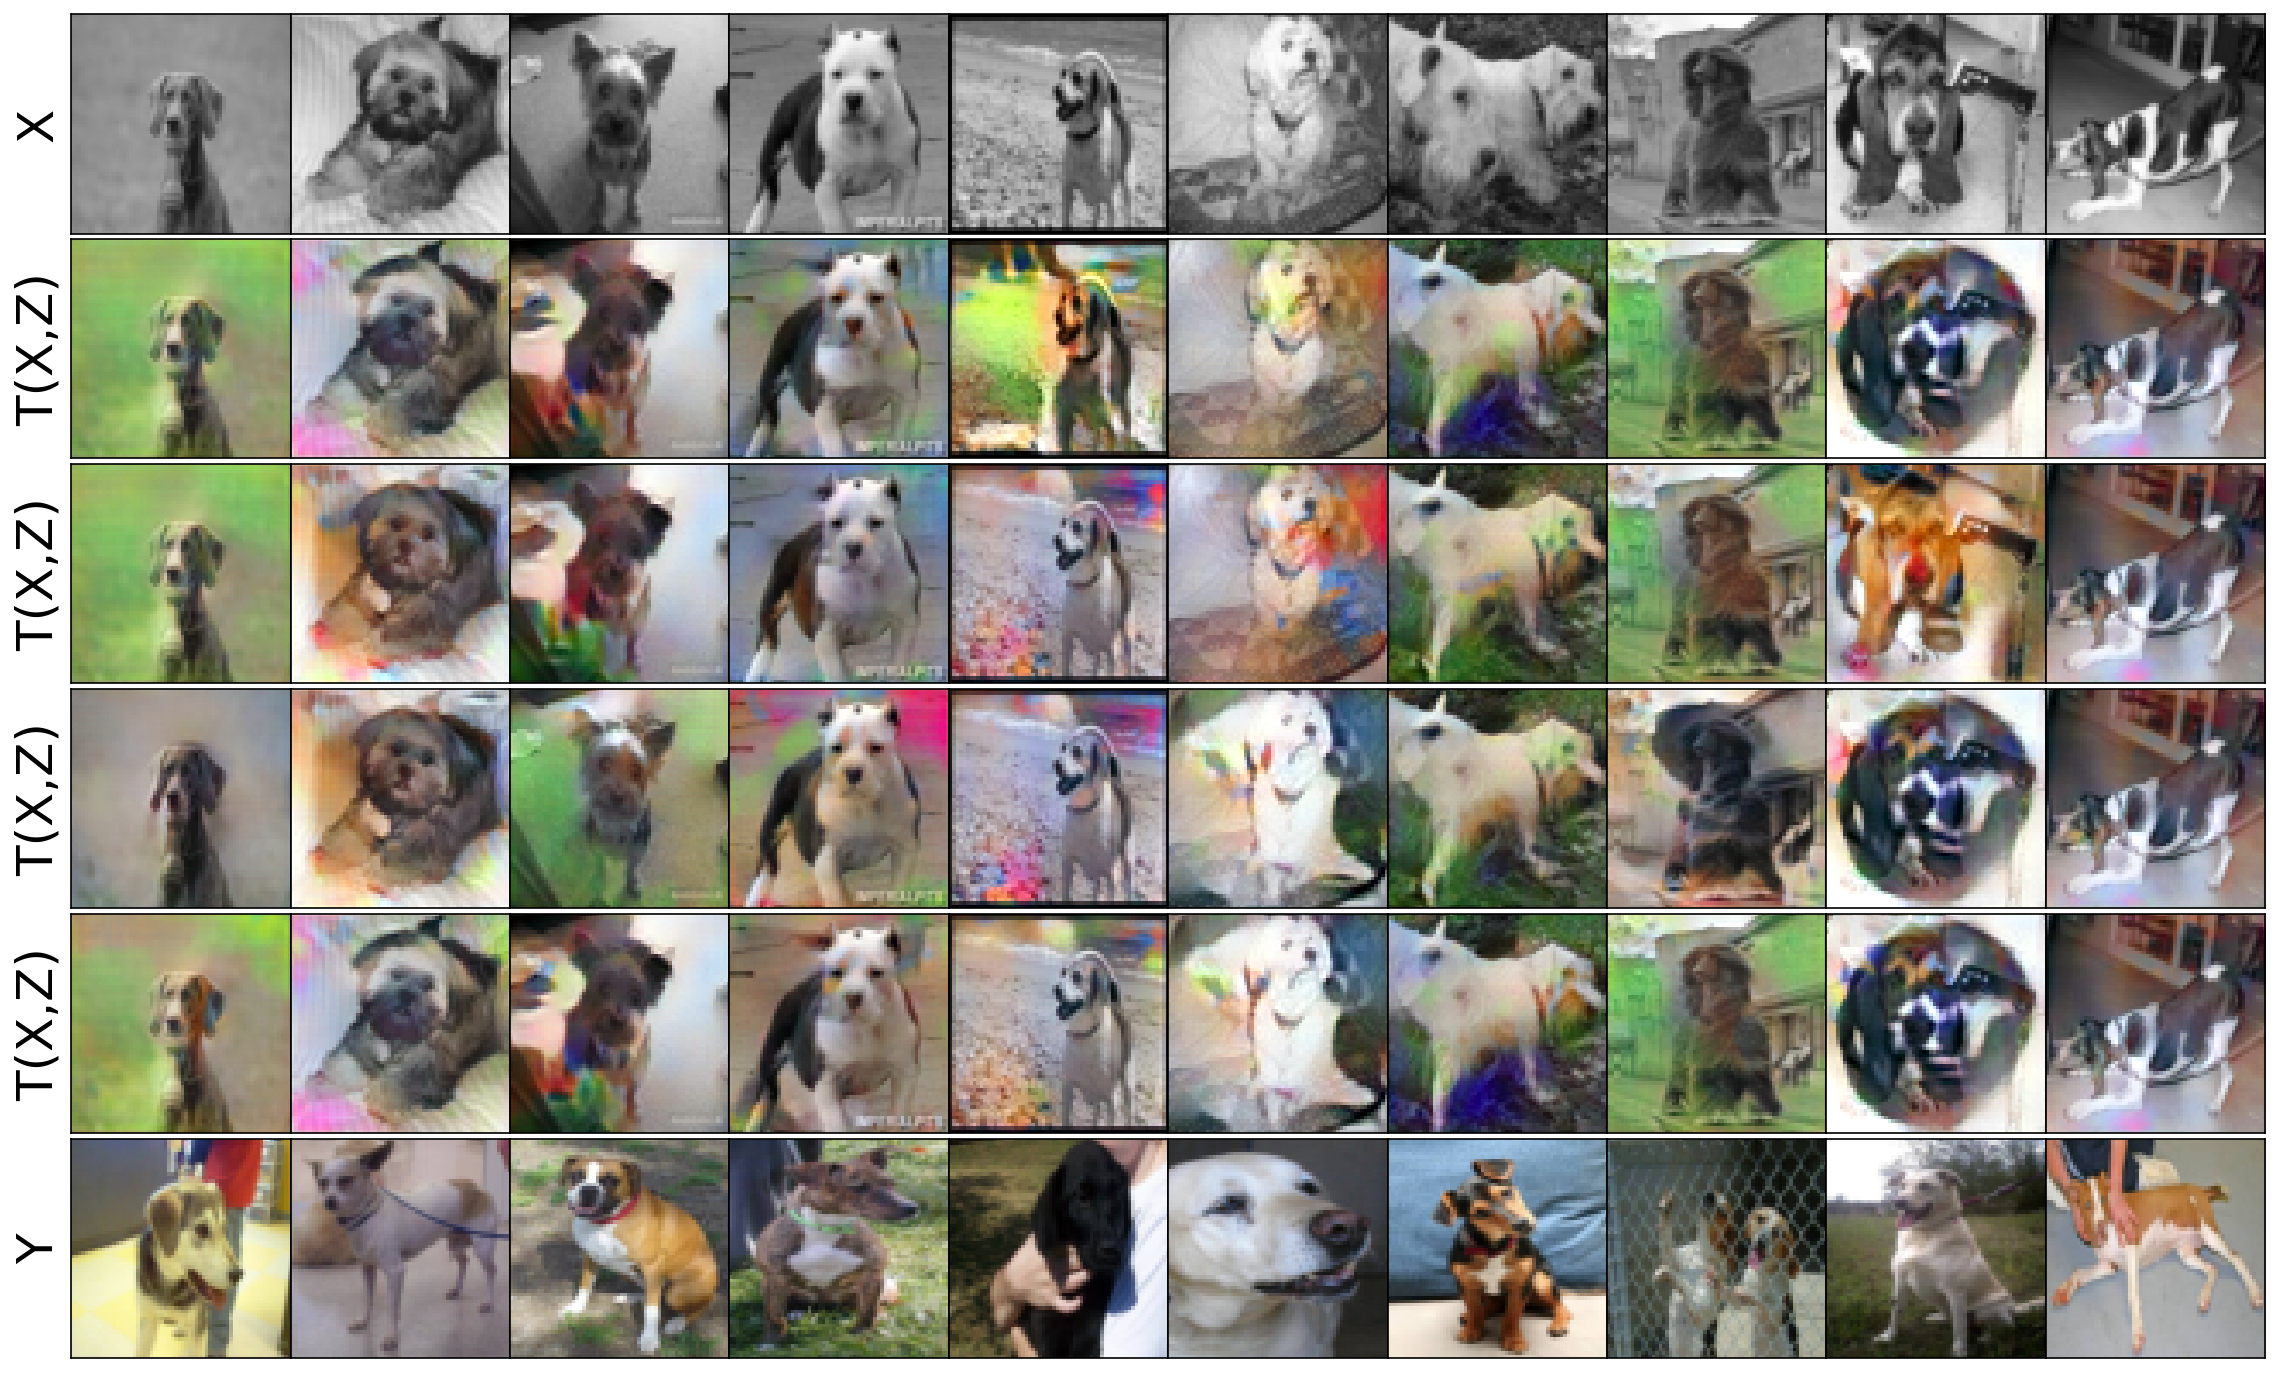

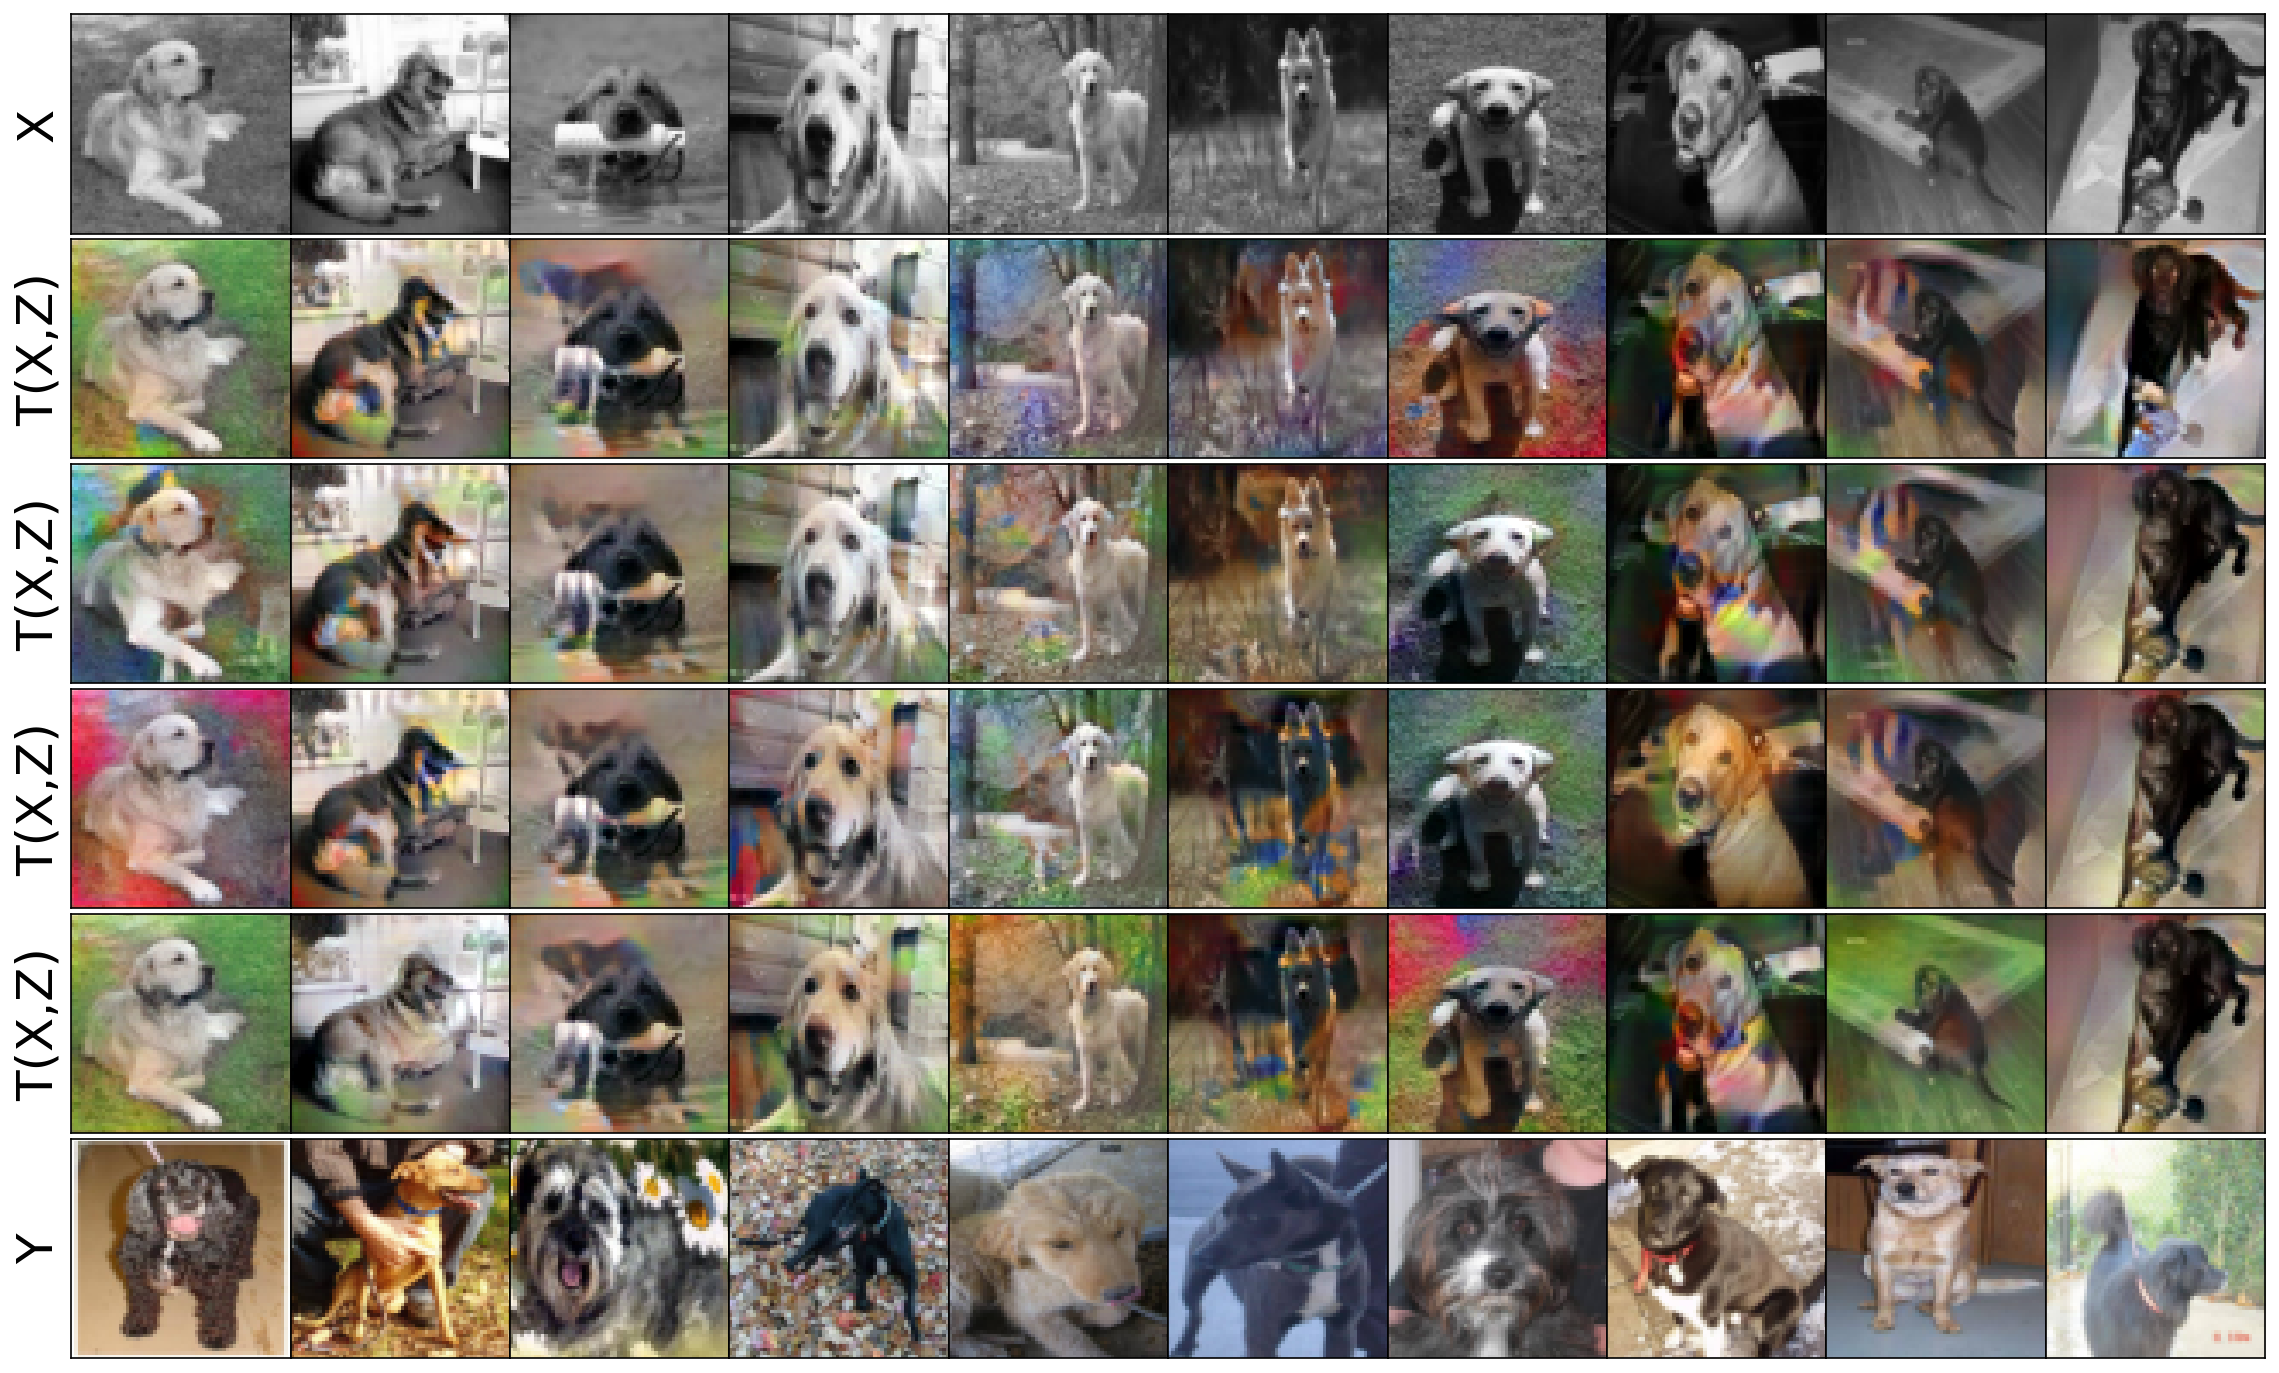

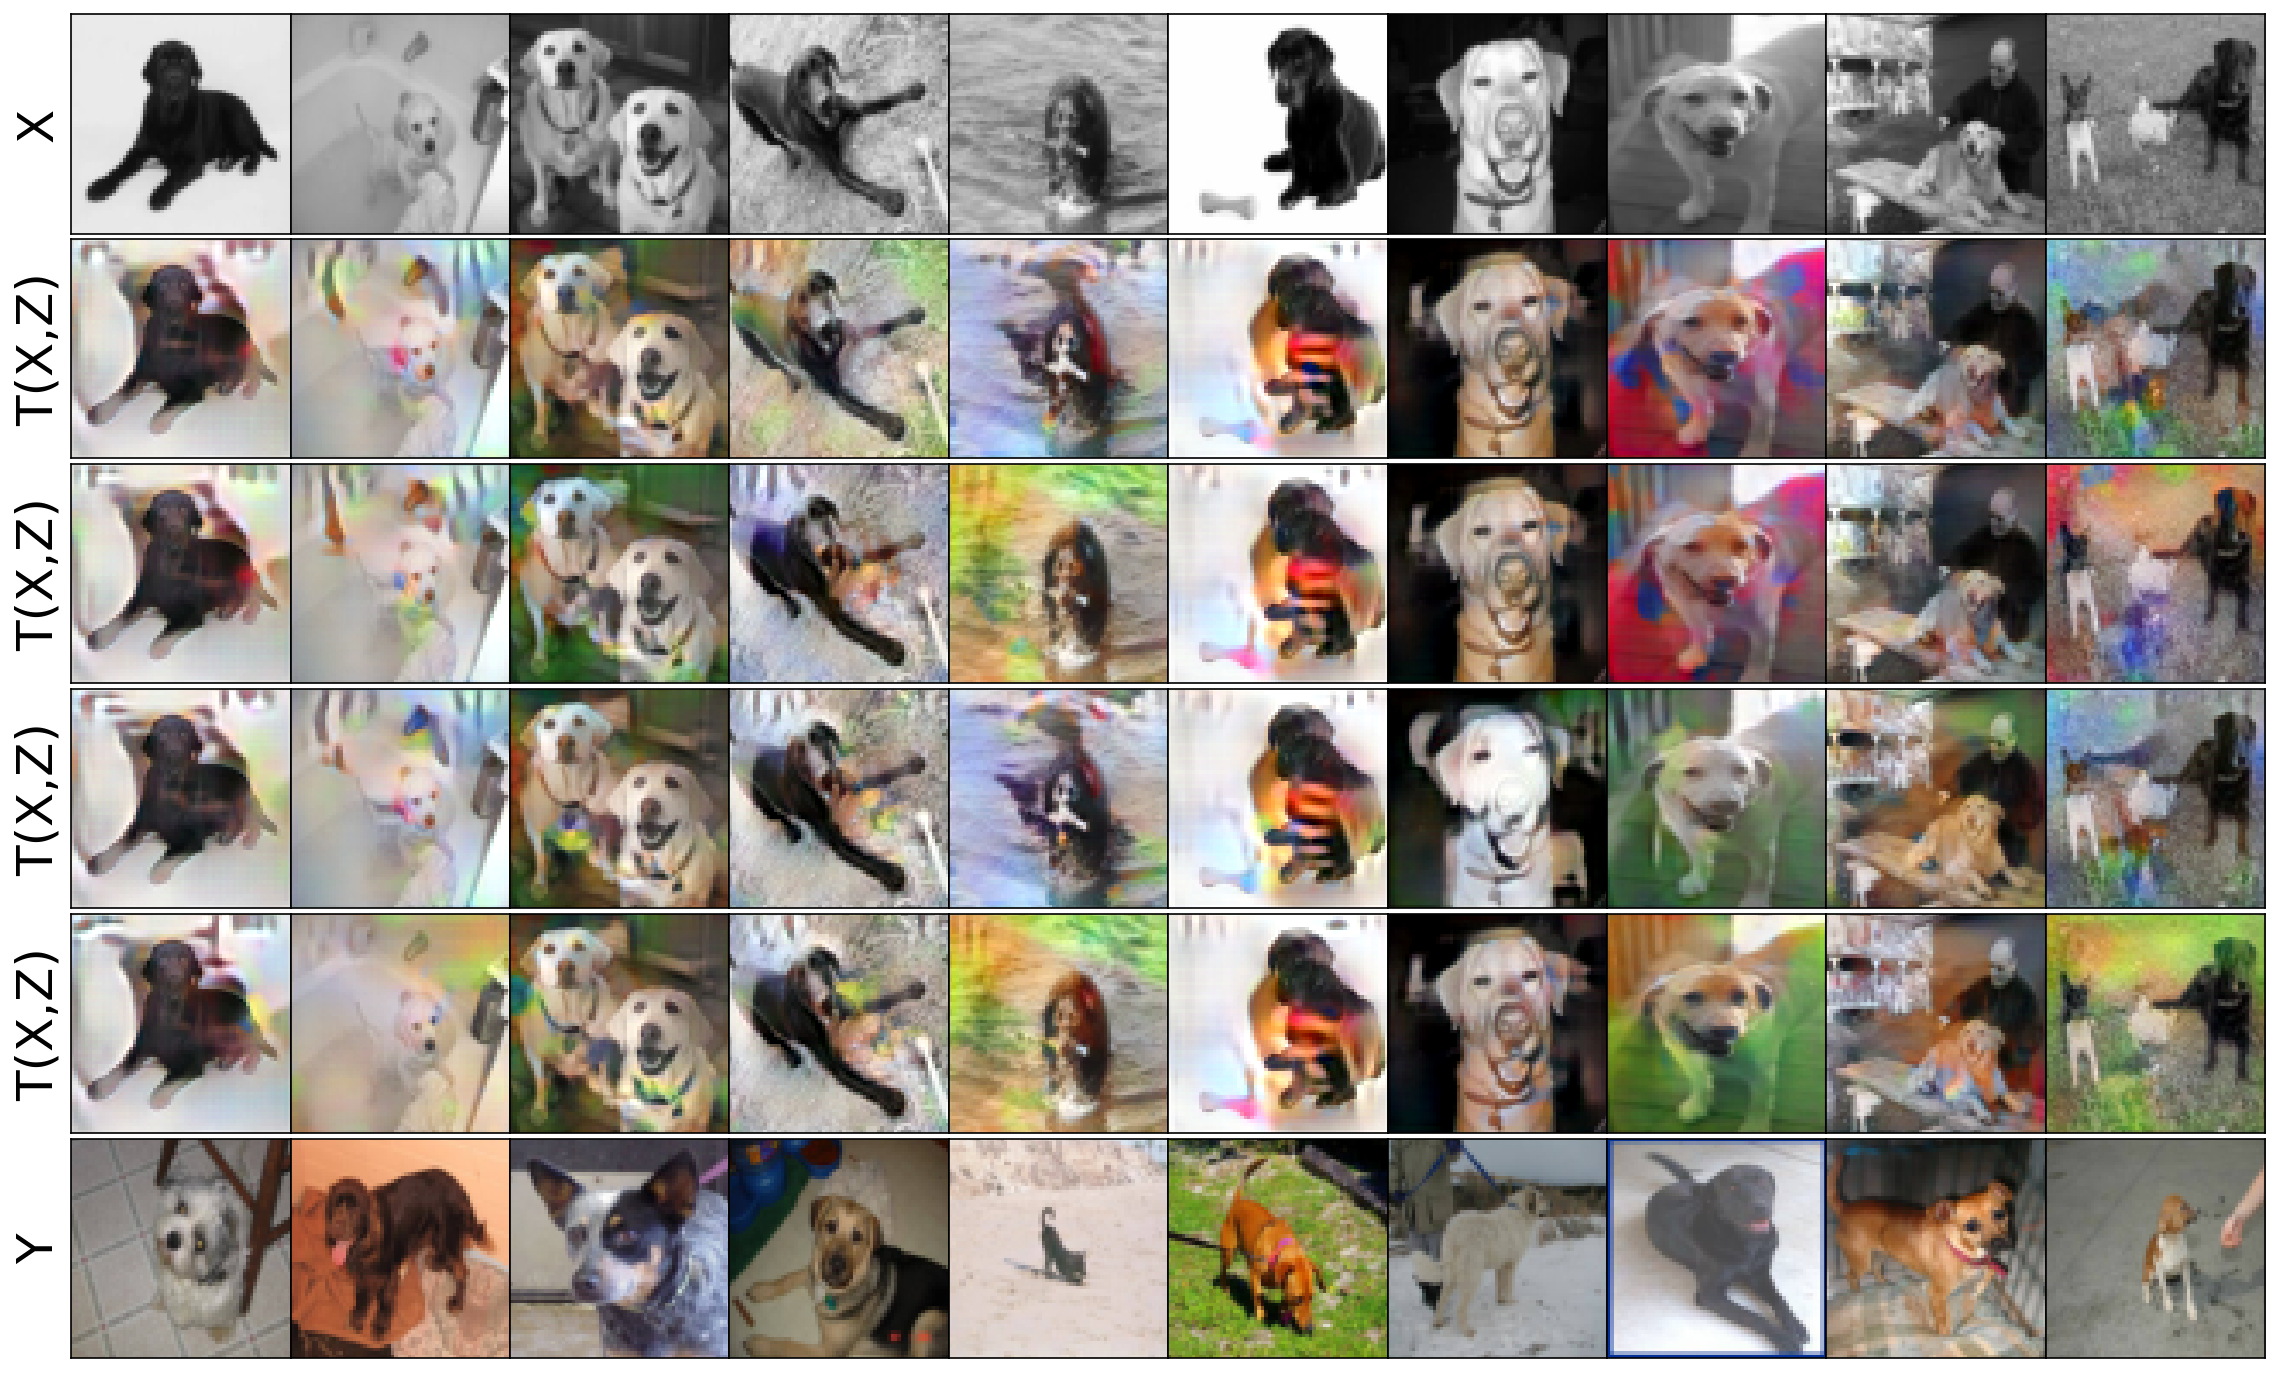

Step 17041
Step 17042


KeyboardInterrupt: 

In [65]:
for step in tqdm(range(MAX_STEPS)):
    print(f"Step {step}") 
    gamma = min(GAMMA1, GAMMA0 + (GAMMA1-GAMMA0) * step / GAMMA_ITERS)

    # T optimization
    unfreeze(T); freeze(f)
    for t_iter in range(T_ITERS): 
        T_opt.zero_grad()
        X = X_sampler.sample(BATCH_SIZE)[:,None].repeat(1,Z_SIZE,1,1,1)
        with torch.no_grad():
            Z = torch.randn(BATCH_SIZE, Z_SIZE, ZC, IMG_SIZE, IMG_SIZE, device='cuda') * Z_STD
            XZ = torch.cat([X, Z], dim=2)
        T_XZ = T(
            XZ.flatten(start_dim=0, end_dim=1)
        ).permute(1,2,3,0).reshape(3, IMG_SIZE, IMG_SIZE, -1, Z_SIZE).permute(3,4,0,1,2)
        
        T_loss = F.mse_loss(X[:,0], T_XZ.mean(dim=1)).mean() - \
        f(T_XZ.flatten(start_dim=0, end_dim=1)).mean() + \
        T_XZ.var(dim=1).mean() * (1 - gamma - 1. / Z_SIZE)
        
        T_loss.backward(); T_opt.step()
    del T_loss, T_XZ, X, Z; gc.collect(); torch.cuda.empty_cache()

    # f optimization
    freeze(T); unfreeze(f)
    X = X_sampler.sample(BATCH_SIZE)
    with torch.no_grad():
        Z = torch.randn(BATCH_SIZE, ZC, X.size(2), X.size(3), device='cuda') * Z_STD
        XZ = torch.cat([X,Z], dim=1)
        T_XZ = T(XZ)
    Y = Y_sampler.sample(BATCH_SIZE)
    f_opt.zero_grad()
    f_loss = f(T_XZ).mean() - f(Y).mean()
    f_loss.backward()
    f_opt.step()
    del f_loss, Y, X, T_XZ, Z, XZ; gc.collect(); torch.cuda.empty_cache()
        
    if step % PLOT_INTERVAL == 0:
        print('Plotting')
        clear_output(wait=True)
        
        fig, axes = plot_Z_images(XZ_fixed, Y_fixed, T)
        plt.show(fig)
        plt.close(fig)
        
        fig, axes = plot_random_Z_images(X_sampler, ZC, Z_STD, Y_sampler, T)
        plt.show(fig)
        plt.close(fig)
        
        fig, axes = plot_Z_images(XZ_test_fixed, Y_test_fixed, T)
        plt.show(fig)
        plt.close(fig)
        
        fig, axes = plot_random_Z_images(X_test_sampler, ZC, Z_STD, Y_test_sampler, T)
        plt.show(fig)
        plt.close(fig)
    
    #if step % CPKT_INTERVAL == CPKT_INTERVAL - 1:
    #    freeze(T); 
        
   #     print('Computing FID')
   #     mu, sigma = get_Z_pushed_loader_stats(T, X_test_sampler.loader, ZC=ZC, Z_STD=Z_STD)
   #     fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
   #     wandb.log({f'FID (Test)' : fid}, step=step)
  #      del mu, sigma
        
   #     torch.save(T.state_dict(), os.path.join(OUTPUT_PATH, f'T_{SEED}_{step}.pt'))
#         torch.save(f.state_dict(), os.path.join(OUTPUT_PATH, f'f_{SEED}_{step}.pt'))
#         torch.save(f_opt.state_dict(), os.path.join(OUTPUT_PATH, f'f_opt_{SEED}_{step}.pt'))
#         torch.save(T_opt.state_dict(), os.path.join(OUTPUT_PATH, f'T_opt_{SEED}_{step}.pt'))
    
    gc.collect(); torch.cuda.empty_cache()

In [ ]:
step

549